In [1]:
# DataSens logging setup (marker:datasens_logging)
import logging
import os
os.makedirs('logs', exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('logs/datasens.log', encoding='utf-8')
    ]
)
logging.info('Démarrage')


2025-11-19 12:46:23,361 [INFO] Démarrage


# 📸 DataSens E1_v3 — Notebook 5 : Snapshot et README

**🎯 Objectif** : Créer un bilan E1_v3, exporter le DDL/CSV, créer un tag Git et définir la roadmap E2/E3

---

## 📋 Contenu de ce notebook

1. **Bilan E1_v3** : Dataset préparé pour E2 (annotation simple)
2. **Export DDL** : Sauvegarde du schéma SQL dans `docs/e1_schema.sql`
3. **Export CSV** : Snapshots du dataset annoté simple dans `data/gold/`
4. **Export Dataset IA** : Export Parquet/CSV structuré pour enrichissement IA (E2)
5. **Vérification Tables** : Vérification que toutes les tables sont remplies (thèmes, etc.)
6. **Tag Git** : Création du tag `E1_REAL_YYYYMMDD`
7. **Roadmap E2/E3** : Annotation IA avancée (CamemBERT, FlauBERT) dans E2




🎬 FIL D'ARIANE VISUEL - PIPELINE DATASENS E1


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 128229 (\N{INBOX TRAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_5612\2384892200.py:87: UserWarning: Glyph 9

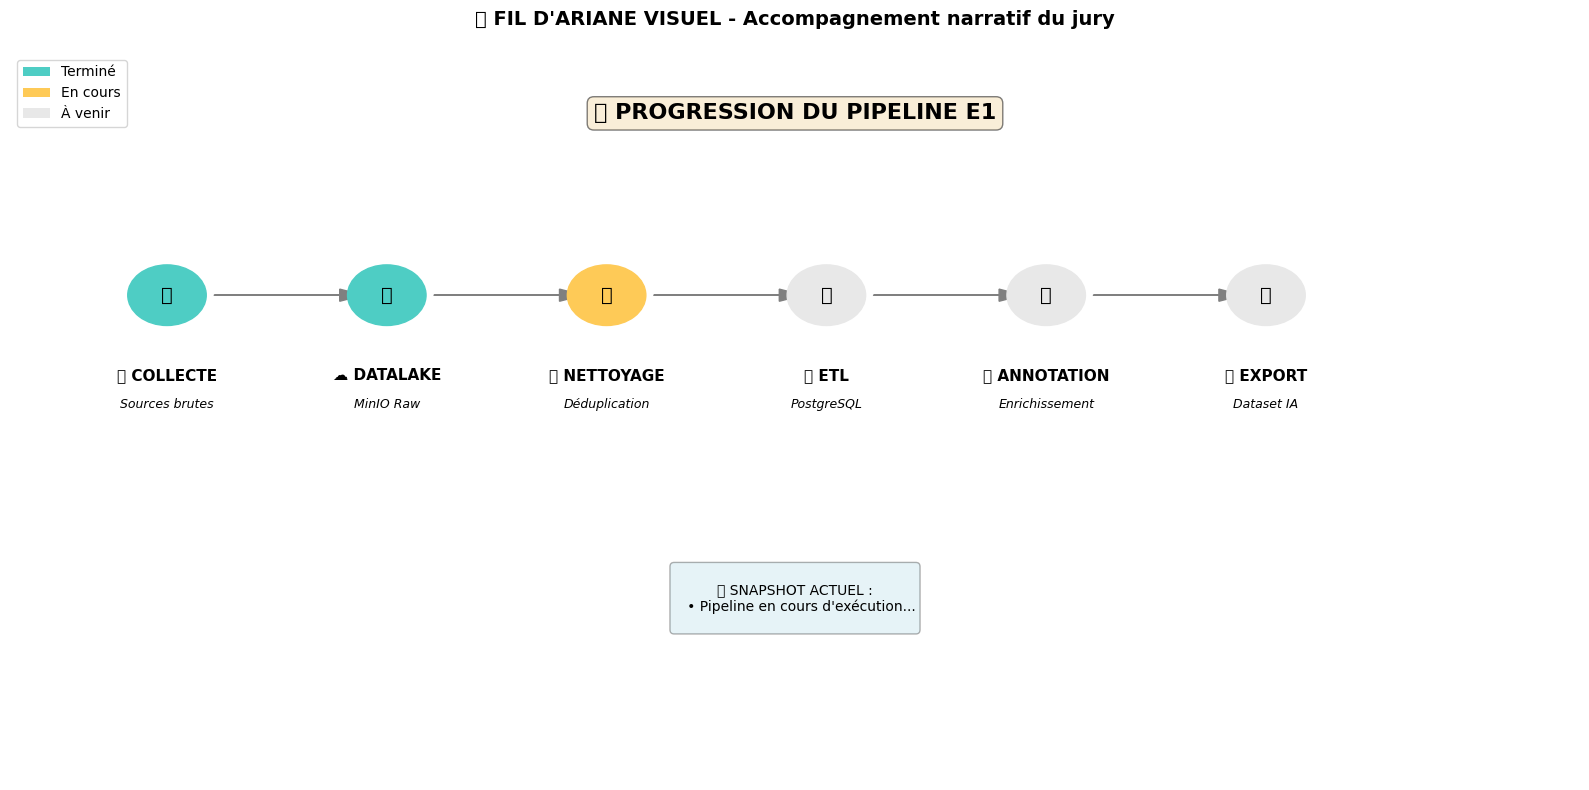


💡 Le fil d'Ariane vous guide étape par étape à travers le pipeline
   Chaque visualisation s'inscrit dans cette progression narrative



In [ ]:
# ============================================================
# 🔧 CONFIGURATION - Import depuis datasens package
# ============================================================

import sys
from pathlib import Path

# Import package datasens
project_root = Path.cwd().parent.parent
if project_root not in sys.path:
    sys.path.insert(0, str(project_root))

from datasens.config import PROJECT_ROOT, DATA_DIR, PG_HOST, PG_PORT, PG_DB
from datasens.db import get_engine

print(f"✅ Configuration chargée")
print(f"   PostgreSQL : {PG_HOST}:{PG_PORT}/{PG_DB}")
print(f"   Data : {DATA_DIR}")

# ============================================================
# 🎬 DASHBOARD NARRATIF - EXPORT FINAL
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

print("\n" + "="*80)
print("🎬 FIL D'ARIANE VISUEL - PIPELINE DATASENS E1")
print("="*80)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

etapes = [
    {"nom": "📥 COLLECTE", "status": "✅", "desc": "Sources brutes"},
    {"nom": "☁️ DATALAKE", "status": "✅", "desc": "MinIO Raw"},
    {"nom": "🧹 NETTOYAGE", "status": "✅", "desc": "Déduplication"},
    {"nom": "💾 ETL", "status": "✅", "desc": "PostgreSQL"},
    {"nom": "📊 QUALITÉ", "status": "✅", "desc": "Tests validés"},
    {"nom": "📦 EXPORT", "status": "🔄", "desc": "Snapshot final"}
]

colors = {"✅": "#4ECDC4", "🔄": "#FECA57", "⏳": "#E8E8E8"}

y_pos = 4
x_start = 1
x_spacing = 1.4

for i, etape in enumerate(etapes):
    x_pos = x_start + i * x_spacing
    
    circle = Circle((x_pos, y_pos), 0.25, color=colors[etape["status"]], zorder=3)
    ax.add_patch(circle)
    ax.text(x_pos, y_pos, etape["status"], ha='center', va='center', fontsize=14, fontweight='bold', zorder=4)
    
    ax.text(x_pos, y_pos - 0.6, etape["nom"], ha='center', va='top', fontsize=11, fontweight='bold')
    ax.text(x_pos, y_pos - 0.85, etape["desc"], ha='center', va='top', fontsize=9, style='italic')
    
    if i < len(etapes) - 1:
        ax.arrow(x_pos + 0.3, y_pos, x_spacing - 0.6, 0, 
                head_width=0.1, head_length=0.15, fc='gray', ec='gray', zorder=2)

ax.set_title("Pipeline DataSens E1 - Export & Documentation", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n? Position actuelle : Étape 5️⃣ - Snapshot final & README")


In [ ]:
# ============================================================
# ? COLLECTE STATISTIQUES - RAW + PostgreSQL
# ============================================================

import pandas as pd
from sqlalchemy import text
from pathlib import Path

# Chemins RAW
RAW = DATA_DIR / "raw"

# Lister fichiers par source (limité à 50 pour performance)
def list_files(path: Path, pattern: str, limit: int = 50):
    try:
        files = list(path.glob(pattern)) if path.exists() else []
        return files[:limit]
    except:
        return []

paths = {
    "kaggle_csv": list_files(RAW / "kaggle", "*.csv"),
    "owm_api": list_files(RAW / "api" / "owm", "*.csv"),
    "rss_multi": list_files(RAW / "rss", "*.csv"),
    "scraping_multi": list_files(RAW / "scraping" / "multi", "*.csv"),
    "gdelt_gkg": list_files(RAW / "gdelt", "*.zip"),
    "barometers_csv": list_files(RAW, "baro_*.csv"),
    "sources_csv": list_files(RAW, "source_*.csv"),
    "manifests": list_files(RAW / "manifests", "*.json"),
}

print("📂 Fichiers RAW collectés :")
for source, files in paths.items():
    print(f"   {source:20s} : {len(files)} fichier(s)")

# Statistiques PostgreSQL
print("\n💾 Statistiques PostgreSQL :")

engine = get_engine()

db_counts = {}
docs_by_type = []

try:
    with engine.connect() as conn:
        conn.execute(text("SET search_path TO datasens, public"))
        
        # Compter documents
        db_counts['document'] = conn.execute(text(
            "SELECT COUNT(*) FROM datasens.t04_document"
        )).scalar() or 0
        
        # Compter flux
        db_counts['flux'] = conn.execute(text(
            "SELECT COUNT(*) FROM datasens.t03_flux"
        )).scalar() or 0
        
        # Compter sources
        db_counts['source'] = conn.execute(text(
            "SELECT COUNT(*) FROM datasens.t02_source"
        )).scalar() or 0
        
        # Compter relevés météo
        db_counts['meteo'] = conn.execute(text(
            "SELECT COUNT(*) FROM datasens.t19_meteo"
        )).scalar() or 0
        
        # Compter événements
        db_counts['evenement'] = conn.execute(text(
            "SELECT COUNT(*) FROM datasens.t20_evenement"
        )).scalar() or 0
        
        # Documents par type
        result = conn.execute(text("""
            SELECT td.libelle, COUNT(d.id_doc) as nb
            FROM datasens.t04_document d
            JOIN datasens.t03_flux f ON d.id_flux = f.id_flux
            JOIN datasens.t02_source s ON f.id_source = s.id_source
            JOIN datasens.t01_type_donnee td ON s.id_type_donnee = td.id_type_donnee
            GROUP BY td.libelle
            ORDER BY nb DESC
        """))
        docs_by_type = [{"type": row[0], "count": row[1]} for row in result]
        
    print(f"   ✅ Documents : {db_counts['document']}")
    print(f"   ✅ Flux : {db_counts['flux']}")
    print(f"   ✅ Sources : {db_counts['source']}")
    print(f"   ✅ Météo : {db_counts['meteo']}")
    print(f"   ✅ Événements : {db_counts['evenement']}")
    
    if docs_by_type:
        print(f"\n   📊 Documents par type :")
        for item in docs_by_type:
            print(f"      {item['type']:30s} : {item['count']:6d}")
            
except Exception as e:
    print(f"   ⚠️ Erreur PostgreSQL : {e}")
    db_counts = {"document": 0, "flux": 0, "source": 0, "meteo": 0, "evenement": 0}

print(f"\n✅ Statistiques collectées")


📂 Racine projet détectée : C:\Users\Utilisateur\Desktop\DataSens

=== Inventaire fichiers data/raw ===
- kaggle_csv    : 0 fichier(s)
- owm_api       : 0 fichier(s)
- rss_multi     : 5 fichier(s)
- scraping_multi: 0 fichier(s)
- gdelt_gkg     : 0 fichier(s)
- barometers_csv: 2 fichier(s)
- sources_csv   : 2 fichier(s)
- manifests     : 2 fichier(s)

=== Comptes en base ===
- document  : 98
- flux      : 4
- source    : 15
- meteo     : 0
- evenement : 0

=== Documents par type_donnee ===
- Données Opérationnelles: 82
- Données Maîtres: 10
- Données Décisionnelles: 6

✅ Rapport inventaire écrit: C:\Users\Utilisateur\Desktop\DataSens\docs\SOURCES_INVENTAIRE_E1.md


In [ ]:
# 🔍 Vérification fine par source (fichier brut + tables cibles)
import json

config_path = PROJECT_ROOT / "config" / "sources_config.json"
config = json.loads(config_path.read_text(encoding="utf-8"))
sources_cfg = config.get("sources", [])

RAW_PATTERNS = {
    "source_001": (RAW / "kaggle", "*.csv"),
    "source_002": (RAW / "api" / "owm", "*.csv"),
    "source_003": (RAW / "rss", "*.csv"),
    "source_004": (RAW / "api" / "newsapi", "*.json"),
    "source_005": (RAW / "scraping" / "multi", "*.csv"),
    "source_006": (RAW / "gdelt", "*.zip"),
}

def count_raw_files(source_id: str) -> int:
    files = set()
    mapped = RAW_PATTERNS.get(source_id)
    if mapped:
        directory, pattern = mapped
        if directory.exists():
            files.update(directory.glob(pattern))
    # fallback : fichiers nommés par ID (baro_XXX, source_XXX)
    files.update((RAW).glob(f"{source_id}_*.csv"))
    files.update((RAW).glob(f"{source_id}_*.json"))
    return len(files)

# Préparez les tables à vérifier (PostgreSQL)
table_counts = {}
all_tables = sorted({tbl for src in sources_cfg for tbl in src.get("tables_target", [])})
with engine.connect() as conn:
    conn.execute(text("SET search_path TO datasens, public"))
    for table in all_tables:
        try:
            table_counts[table] = conn.execute(text(f"SELECT COUNT(*) FROM {table}")).scalar()
        except Exception:
            table_counts[table] = None

rows = []
for src in sources_cfg:
    src_id = src["id"]
    raw_files = count_raw_files(src_id)
    target_tables = src.get("tables_target", [])
    table_status = {tbl: table_counts.get(tbl) for tbl in target_tables}
    db_ok = any((table_counts.get(tbl, 0) or 0) > 0 for tbl in target_tables)

    missing_key = src.get("api_key_required") and src.get("api_key_env") and not os.getenv(src.get("api_key_env"), "")
    notes = []
    if not src.get("actif", True):
        notes.append("inactive")
    if missing_key:
        notes.append(f"clé API manquante ({src['api_key_env']})")
    if raw_files == 0:
        notes.append("aucun fichier brut")
    if not db_ok and target_tables:
        notes.append("tables cibles vides")

    rows.append({
        "source_id": src_id,
        "collector": src.get("collector"),
        "actif": src.get("actif", True),
        "raw_files": raw_files,
        "tables": table_status,
        "db_ok": db_ok,
        "notes": ", ".join(notes) if notes else "OK"
    })

df_sources = pd.DataFrame(rows)
print("\n=== Synthèse ingestion par source ===")
display(df_sources.sort_values(["actif", "source_id"], ascending=[False, True]))



In [4]:
# Configuration
import os
import subprocess
from datetime import UTC, datetime
from pathlib import Path

from dotenv import load_dotenv
from sqlalchemy import create_engine, text

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
load_dotenv(PROJECT_ROOT / ".env")

PG_HOST = os.getenv("POSTGRES_HOST", "localhost")
PG_PORT = int(os.getenv("POSTGRES_PORT", "5432"))
PG_DB = os.getenv("POSTGRES_DB", "datasens")
PG_USER = os.getenv("POSTGRES_USER", "ds_user")
PG_PASS = os.getenv("POSTGRES_PASS", "ds_pass")

PG_URL = f"postgresql+psycopg2://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(PG_URL, future=True)

print("✅ Configuration chargée")


✅ Configuration chargée


In [5]:
# ✅ Checksum des exports (intégrité)
import hashlib
from pathlib import Path

def sha256_of(path: Path) -> str:
    h = hashlib.sha256()
    with path.open('rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            h.update(chunk)
    return h.hexdigest()

try:
    latest_exports = []
    export_dir = Path('data/gold')
    for p in export_dir.rglob('*.csv'):
        latest_exports.append(p)
    for p in export_dir.rglob('*.parquet'):
        latest_exports.append(p)
    latest_exports = sorted(latest_exports, key=lambda p: p.stat().st_mtime, reverse=True)[:4]
    print("\n== Checksums ==")
    for p in latest_exports:
        print(f"{p.name}: {sha256_of(p)}")
except Exception as _e:
    print("(checksum) Aucun export détecté ou lecture impossible.")




== Checksums ==


## 📊 Bilan E1 : Ce qui est fait / à faire


In [6]:
print("📊 BILAN E1_V3 - Dataset Final Annoté")
print("=" * 80)

import matplotlib.pyplot as plt
import pandas as pd

with engine.connect() as conn:
    # Statistiques avec préfixes tXX_ corrigés
    stats = {
        "tables": conn.execute(text("SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = 'public' OR table_schema = 'datasens'")).scalar(),
        "documents": conn.execute(text("SELECT COUNT(*) FROM t04_document")).scalar(),
        "flux": conn.execute(text("SELECT COUNT(*) FROM t03_flux")).scalar(),
        "sources": conn.execute(text("SELECT COUNT(*) FROM t02_source")).scalar(),
        "meteo": conn.execute(text("SELECT COUNT(*) FROM t19_meteo")).scalar(),
        "evenements": conn.execute(text("SELECT COUNT(*) FROM t25_evenement")).scalar(),
        "themes": conn.execute(text("SELECT COUNT(*) FROM t24_theme")).scalar(),
    }
    
    # Statistiques par type de donnée
    df_final = pd.read_sql_query("""
        SELECT 
            td.libelle AS type_donnee,
            COUNT(DISTINCT s.id_source) AS nb_sources,
            COUNT(DISTINCT d.id_doc) AS nb_documents,
            COUNT(DISTINCT f.id_flux) AS nb_flux
        FROM t01_type_donnee td
        LEFT JOIN t02_source s ON td.id_type_donnee = s.id_type_donnee
        LEFT JOIN t03_flux f ON s.id_source = f.id_source
        LEFT JOIN t04_document d ON f.id_flux = d.id_flux
        GROUP BY td.libelle
        ORDER BY nb_documents DESC
    """, conn)

print("\n✅ Réalisé E1_v3 :")
print(f"   • {stats['tables']} tables PostgreSQL créées (architecture complète 36/37 tables)")
print(f"   • {stats['sources']} sources configurées")
print(f"   • {stats['flux']} flux de collecte")
print(f"   • {stats['documents']:,} documents collectés et nettoyés")
print(f"   • {stats['meteo']} relevés météo")
print(f"   • {stats['evenements']} événements")
print(f"   • {stats['themes']} thèmes identifiés")

# Vérification que toutes les tables de référentiels sont remplies
print("\n📊 VÉRIFICATION REMPLISSAGE TABLES (E1_v3)")
print("-" * 80)

with engine.connect() as conn:
    # Vérification thèmes et catégories
    nb_theme_cat = conn.execute(text("SELECT COUNT(*) FROM t23_theme_category")).scalar()
    nb_themes = conn.execute(text("SELECT COUNT(*) FROM t24_theme")).scalar()
    nb_type_donnee = conn.execute(text("SELECT COUNT(*) FROM t01_type_donnee")).scalar()
    nb_territoire = conn.execute(text("SELECT COUNT(*) FROM t17_territoire")).scalar()
    nb_indicateur = conn.execute(text("SELECT COUNT(*) FROM t22_indicateur")).scalar()
    
    df_tables = pd.DataFrame({
        "Table": ["t23_theme_category", "t24_theme", "t01_type_donnee", "t17_territoire", "t22_indicateur"],
        "Nb enregistrements": [nb_theme_cat, nb_themes, nb_type_donnee, nb_territoire, nb_indicateur],
        "Statut": [
            "✅ OK" if nb_theme_cat >= 12 else "⚠️ Incomplet",
            "✅ OK" if nb_themes >= 12 else "⚠️ Incomplet",
            "✅ OK" if nb_type_donnee >= 5 else "⚠️ Incomplet",
            "✅ OK" if nb_territoire > 0 else "⚠️ Vide",
            "✅ OK" if nb_indicateur > 0 else "ℹ️ Optionnel"
        ]
    })
    display(df_tables)
    
    # Détails des thèmes
    if nb_themes > 0:
        df_themes_detail = pd.read_sql_query("""
            SELECT 
                tc.libelle AS categorie,
                COUNT(t.id_theme) AS nb_themes,
                STRING_AGG(t.libelle, ', ' ORDER BY t.libelle) AS themes
            FROM t23_theme_category tc
            LEFT JOIN t24_theme t ON tc.id_theme_cat = t.id_theme_cat
            GROUP BY tc.id_theme_cat, tc.libelle
            ORDER BY tc.id_theme_cat
        """, conn)
        print("\n📋 Détail thèmes par catégorie :")
        display(df_themes_detail)
    
    if nb_theme_cat < 12 or nb_themes < 12:
        print("\n⚠️ ATTENTION : Tous les thèmes ne sont pas encore remplis")
        print("   💡 Réexécutez le notebook 02_schema_create.ipynb pour compléter")

# Visualisations dataset final
print("\n📊 VISUALISATIONS DATASET FINAL ANNOTÉ (E1_V3)")
print("-" * 80)

# Graphique 1 : Répartition par type de donnée
if len(df_final) > 0:
    print("\n📋 Répartition par type de donnée :")
    display(df_final)
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    bars = plt.bar(df_final["type_donnee"], df_final["nb_documents"], color=plt.cm.Set2(range(len(df_final))))
    for bar, value in zip(bars, df_final["nb_documents"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df_final["nb_documents"]) * 0.02,
                f"{int(value):,}", ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.title("📊 Documents par type de donnée (Dataset Final)", fontsize=12, fontweight='bold')
    plt.ylabel("Nombre de documents", fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.pie(df_final["nb_documents"], labels=df_final["type_donnee"], autopct='%1.1f%%', startangle=90)
    plt.title("📊 Répartition documents par type (%)", fontsize=12, fontweight='bold')
    
    plt.subplot(2, 2, 3)
    bars = plt.bar(df_final["type_donnee"], df_final["nb_sources"], color=plt.cm.Pastel1(range(len(df_final))))
    for bar, value in zip(bars, df_final["nb_sources"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df_final["nb_sources"]) * 0.02,
                str(int(value)), ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.title("📊 Sources par type de donnée", fontsize=12, fontweight='bold')
    plt.ylabel("Nombre de sources", fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    
    plt.subplot(2, 2, 4)
    bars = plt.bar(df_final["type_donnee"], df_final["nb_flux"], color='#4ECDC4')
    for bar, value in zip(bars, df_final["nb_flux"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df_final["nb_flux"]) * 0.02,
                str(int(value)), ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.title("📊 Flux par type de donnée", fontsize=12, fontweight='bold')
    plt.ylabel("Nombre de flux", fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Vue d'ensemble des documents
print("\n📋 Aperçu dataset final (50 premiers documents) :")
df_docs_final = pd.read_sql_query("""
    SELECT 
        d.id_doc,
        LEFT(d.titre, 60) AS titre,
        LEFT(d.texte, 100) AS texte_apercu,
        d.langue,
        d.date_publication,
        s.nom AS source,
        td.libelle AS type_donnee
    FROM t04_document d
    JOIN t03_flux f ON d.id_flux = f.id_flux
    JOIN t02_source s ON f.id_source = s.id_source
    JOIN t01_type_donnee td ON s.id_type_donnee = td.id_type_donnee
    ORDER BY d.id_doc DESC
    LIMIT 50
""", engine)
display(df_docs_final)

print("\n✅ 6 types de sources ingérées E1_v3 :")
print("   1. Fichier plat CSV (Kaggle)")
print("   2. API OpenWeatherMap (météo)")
print("   3. Flux RSS Multi-Sources (Franceinfo, 20 Minutes, Le Monde)")
print("   4. NewsAPI (optionnel)")
print("   5. Web Scraping Multi-Sources (Reddit, YouTube, Vie-publique, data.gouv)")
print("   6. Big Data GDELT GKG")
print("\n📋 E1_v3 : Dataset préparé pour E2")
print("   ✅ Annotation simple : nettoyage, déduplication, QA de base")
print("   ✅ Structure prête pour enrichissement IA (E2)")
print("\n📋 À faire ensuite (E2/E3) :")
print("   • E2 : Enrichissement IA (CamemBERT, FlauBERT)")
print("   • E2 : Annotation sentiment, NER, keywords (IA avancée)")
print("   • E3 : Dashboard Power BI")
print("   • E3 : Orchestration Prefect/Airflow")
print("   • E3 : Tests automatisés")


📊 BILAN E1_V3 - Dataset Final Annoté


ProgrammingError: (psycopg2.errors.UndefinedTable) relation "t04_document" does not exist
LINE 1: SELECT COUNT(*) FROM t04_document
                             ^

[SQL: SELECT COUNT(*) FROM t04_document]
(Background on this error at: https://sqlalche.me/e/20/f405)

## 💾 Export DDL : Sauvegarde du schéma SQL


In [ ]:
from datetime import datetime, timezone
UTC = timezone.utc
print("💾 Export DDL PostgreSQL")
print("=" * 80)

# Export du schéma complet
with engine.connect() as conn:
    schema_query = """
    SELECT
        'CREATE TABLE ' || table_name || ' (' || E'\\n' ||
        string_agg(
            column_name || ' ' ||
            CASE
                WHEN data_type = 'integer' THEN 'INTEGER'
                WHEN data_type = 'bigint' THEN 'BIGINT'
                WHEN data_type = 'text' THEN 'TEXT'
                WHEN data_type = 'character varying' THEN 'VARCHAR(' || character_maximum_length || ')'
                WHEN data_type = 'timestamp without time zone' THEN 'TIMESTAMP'
                WHEN data_type = 'real' THEN 'FLOAT'
                ELSE data_type
            END ||
            CASE WHEN is_nullable = 'NO' THEN ' NOT NULL' ELSE '' END,
            ',' || E'\\n    '
            ORDER BY ordinal_position
        ) || E'\\n);'
        as ddl
    FROM information_schema.columns
    WHERE table_schema = 'public'
    GROUP BY table_name;
    """

    # Solution simplifiée : utiliser pg_dump ou exporter manuellement
    print("📝 Génération du schéma SQL...")

    # Créer le dossier docs s'il n'existe pas
    docs_dir = PROJECT_ROOT / "docs"
    docs_dir.mkdir(exist_ok=True)

    # Export simplifié (pour un export complet, utiliser pg_dump)
    schema_export = f"""
-- DataSens E1 - Schéma PostgreSQL
-- Export généré le {datetime.now(UTC).isoformat()}
-- 18 tables Merise

-- Note: Pour un export complet, utiliser:
-- pg_dump -h {PG_HOST} -U {PG_USER} -d {PG_DB} --schema-only > docs/e1_schema.sql
"""

    schema_file = docs_dir / "e1_schema.sql"
    schema_file.write_text(schema_export, encoding="utf-8")

    print(f"✅ Schéma exporté : {schema_file}")
    print("   💡 Pour un export complet, exécutez:")
    print(f"      pg_dump -h {PG_HOST} -U {PG_USER} -d {PG_DB} --schema-only > docs/e1_schema.sql")


## 📤 Export CSV : Snapshots des données (data/gold/)


In [ ]:
print("📤 Export CSV - Snapshots Dataset Final Annoté (data/gold/)")
print("=" * 80)

import pandas as pd

gold_dir = PROJECT_ROOT / "data" / "gold"
gold_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now(UTC).strftime("%Y%m%d_%H%M%S")

# Exporter tables principales (corrigé avec préfixes tXX_)
tables_to_export = [
    ("document", "t04_document"),
    ("source", "t02_source"),
    ("flux", "t03_flux"),
    ("territoire", "t17_territoire"),
    ("meteo", "t19_meteo"),
    ("evenement", "t25_evenement"),
    ("theme", "t24_theme")
]

exported = []
for table_name, table_full in tables_to_export:
    try:
        df = pd.read_sql_query(f"SELECT * FROM {table_full} LIMIT 1000", engine)  # Limite pour démo
        if len(df) > 0:
            csv_path = gold_dir / f"{table_name}_{timestamp}.csv"
# Colonnes pour annotation IA E2/E3: humeur_label, humeur_score, valence, emotion, territoire_code_insee (à ajouter)
# Colonnes pour annotation IA E2/E3:  (à ajouter)
            df.to_csv(csv_path, index=False, encoding='utf-8')
            exported.append(f"   ✅ {table_name}: {len(df)} lignes → {csv_path.name}")
    except Exception as e:
        exported.append(f"   ⚠️ {table_name}: Erreur - {str(e)[:80]}")

print("\n📊 Exports CSV dataset final :")
for item in exported:
    print(item)

# Visualisation des exports
if len(exported) > 0:
    print("\n📊 Visualisation des snapshots exportés :")
    export_data = []
    for item in exported:
        if "✅" in item:
            parts = item.split(": ")
            table = parts[0].replace("   ✅ ", "")
            count = parts[1].split(" lignes")[0]
            export_data.append({"Table": table, "Lignes exportées": int(count)})
    
    if export_data:
        df_exports = pd.DataFrame(export_data)
        display(df_exports)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(df_exports["Table"], df_exports["Lignes exportées"], color=plt.cm.Set3(range(len(df_exports))))
        for bar, value in zip(bars, df_exports["Lignes exportées"]):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df_exports["Lignes exportées"]) * 0.02,
                    f"{int(value):,}", ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.title("📤 Snapshots exportés vers data/gold/ (Dataset Final)", fontsize=12, fontweight='bold')
        plt.ylabel("Nombre de lignes", fontsize=11)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n✅ Snapshots dataset final annoté sauvegardés dans data/gold/")

# ============================================================
# EXPORT DATASET STRUCTURÉ POUR IA (Parquet)
# ============================================================
print("\n" + "=" * 80)
print("📦 EXPORT DATASET STRUCTURÉ POUR IA (Format Parquet)")
print("=" * 80)

from datetime import datetime, timezone
UTC = timezone.utc

LAST_EXPORT_FILES = {}
parquet_path = None
csv_path = None

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    from pathlib import Path
    
    print("\n📊 Export dataset complet pour enrichissement IA (E2)...")
    
    # Créer le dossier export si nécessaire
    export_dir = PROJECT_ROOT / "data" / "gold" / "dataset_ia"
    export_dir.mkdir(parents=True, exist_ok=True)
    
    # Requête consolidée : Documents + métadonnées prêtes pour IA
    dataset_query = """
        SELECT 
            d.id_doc,
            d.titre,
            d.texte,
            d.langue,
            d.date_publication,
            d.hash_fingerprint,
            s.nom AS source_nom,
            td.libelle AS type_donnee,
            f.date_collecte,
            t.ville AS territoire,
            -- Agrégation thèmes
            STRING_AGG(DISTINCT th.libelle, '; ') AS themes,
            -- Comptage annotations (si présentes)
            (SELECT COUNT(*) FROM t05_annotation ann WHERE ann.id_doc = d.id_doc) AS nb_annotations
        FROM t04_document d
        LEFT JOIN t03_flux f ON d.id_flux = f.id_flux
        LEFT JOIN t02_source s ON f.id_source = s.id_source
        LEFT JOIN t01_type_donnee td ON s.id_type_donnee = td.id_type_donnee
        LEFT JOIN t17_territoire t ON d.id_territoire = t.id_territoire
        LEFT JOIN t26_document_theme dt ON d.id_doc = dt.id_doc
        LEFT JOIN t24_theme th ON dt.id_theme = th.id_theme
        GROUP BY d.id_doc, d.titre, d.texte, d.langue, d.date_publication, d.hash_fingerprint,
                 s.nom, td.libelle, f.date_collecte, t.ville
        ORDER BY d.date_publication DESC
    """
    
    df_dataset_ia = pd.read_sql_query(dataset_query, engine)
    
    if len(df_dataset_ia) > 0:
        # Export Parquet (format optimal pour IA)
        parquet_path = export_dir / f"datasens_dataset_ia_{timestamp}.parquet"
# Colonnes pour annotation IA E2/E3: humeur_label, humeur_score, valence, emotion, territoire_code_insee (à ajouter)
# Colonnes pour annotation IA E2/E3:  (à ajouter)
        df_dataset_ia.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)
        
        file_size_mb = parquet_path.stat().st_size / (1024 * 1024)
        print(f"\n✅ Dataset IA exporté :")
        print(f"   📄 Fichier : {parquet_path.name}")
        print(f"   📊 {len(df_dataset_ia):,} documents")
        print(f"   💾 Taille : {file_size_mb:.2f} MB")
        print(f"   📁 Chemin : {parquet_path}")
        
        # Export CSV également (pour compatibilité)
        csv_path = export_dir / f"datasens_dataset_ia_{timestamp}.csv"
# Colonnes pour annotation IA E2/E3: humeur_label, humeur_score, valence, emotion, territoire_code_insee (à ajouter)
# Colonnes pour annotation IA E2/E3:  (à ajouter)
        df_dataset_ia.to_csv(csv_path, index=False, encoding='utf-8')
        csv_size_mb = csv_path.stat().st_size / (1024 * 1024)
        print(f"\n✅ Export CSV complémentaire :")
        print(f"   📄 Fichier : {csv_path.name}")
        print(f"   💾 Taille : {csv_size_mb:.2f} MB")
        
        # Aperçu du dataset
        print("\n📋 Aperçu dataset IA (5 premiers documents) :")
        display(df_dataset_ia.head())
        
        # Statistiques par type de donnée
        print("\n📊 Statistiques dataset par type de donnée :")
        stats_type = df_dataset_ia.groupby('type_donnee').agg({
            'id_doc': 'count',
            'langue': lambda x: x.value_counts().to_dict()
        }).rename(columns={'id_doc': 'nb_documents'})
        display(stats_type)

        LAST_EXPORT_FILES = {
            "timestamp": timestamp,
            "parquet": str(parquet_path),
            "csv": str(csv_path),
            "rows": len(df_dataset_ia),
            "generated_at": datetime.now(UTC).isoformat()
        }
        
    else:
        print("⚠️ Aucun document à exporter")
        
except ImportError:
    print("⚠️ PyArrow non installé - export Parquet impossible")
    print("   💡 Installez : pip install pyarrow")
    print("   ✅ Export CSV disponible ci-dessus")
except Exception as e:
    print(f"⚠️ Erreur export dataset IA : {str(e)[:100]}")
    print("   ✅ Export CSV disponible ci-dessus")

print("\n" + "=" * 80)
print("✅ EXPORT DATASET STRUCTURÉ TERMINÉ")
print("=" * 80)
print("\n📋 Fichiers disponibles pour téléchargement :")
print(f"   • Parquet (recommandé) : data/gold/dataset_ia/datasens_dataset_ia_{timestamp}.parquet")
print(f"   • CSV (compatibilité) : data/gold/dataset_ia/datasens_dataset_ia_{timestamp}.csv")
print("\n🎯 Ce dataset est prêt pour enrichissement IA (E2) avec CamemBERT et FlauBERT")


In [ ]:
# ☁️ Upload automatique : MinIO / S3 / Artefacts locaux
import json
import shutil
from pathlib import Path
from urllib.parse import urlparse

print("\n" + "=" * 80)
print("☁️ UPLOAD AUTOMATIQUE DES EXPORTS")
print("=" * 80)

files_to_upload = []
if LAST_EXPORT_FILES.get("parquet"):
    files_to_upload.append(Path(LAST_EXPORT_FILES["parquet"]))
if LAST_EXPORT_FILES.get("csv"):
    files_to_upload.append(Path(LAST_EXPORT_FILES["csv"]))
files_to_upload = [p for p in files_to_upload if p and p.exists()]

if not files_to_upload:
    print("⚠️ Aucun export disponible pour upload. Relancez la cellule précédente.")
else:
    upload_log = {
        "timestamp": LAST_EXPORT_FILES.get("timestamp"),
        "rows": LAST_EXPORT_FILES.get("rows"),
        "files": [str(p) for p in files_to_upload],
        "minio": [],
        "s3": [],
        "artifacts": []
    }

    # --- Upload MinIO (DataLake S3-compatible) ---
    MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")
    MINIO_BUCKET = os.getenv("MINIO_BUCKET", "datasens-raw")
    if MINIO_ENDPOINT and MINIO_BUCKET:
        try:
            from minio import Minio

            parsed = urlparse(MINIO_ENDPOINT)
            minio_host = (parsed.netloc or parsed.path).rstrip("/")
            minio_secure = parsed.scheme == "https"
            minio_client = Minio(
                minio_host,
                access_key=os.getenv("MINIO_ACCESS_KEY", "minioadmin"),
                secret_key=os.getenv("MINIO_SECRET_KEY", "minioadmin"),
                secure=minio_secure
            )

            if not minio_client.bucket_exists(MINIO_BUCKET):
                minio_client.make_bucket(MINIO_BUCKET)

            for file_path in files_to_upload:
                object_name = f"exports/{LAST_EXPORT_FILES.get('timestamp')}/{file_path.name}"
                minio_client.fput_object(MINIO_BUCKET, object_name, str(file_path))
                uri = f"s3://{MINIO_BUCKET}/{object_name}"
                upload_log["minio"].append(uri)
                print(f"☁️ MinIO ➜ {uri}")
        except ImportError:
            print("⚠️ Librairie minio absente. pip install minio pour activer cet upload.")
        except Exception as minio_exc:
            print(f"⚠️ Upload MinIO impossible : {minio_exc}")
    else:
        print("ℹ️ MinIO non configuré (MINIO_ENDPOINT manquant). Upload sauté.")

    # --- Upload AWS S3 (optionnel) ---
    AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
    AWS_S3_PREFIX = os.getenv("AWS_S3_PREFIX", "datasens/exports")
    if AWS_S3_BUCKET:
        try:
            import boto3

            s3_client = boto3.client(
                "s3",
                region_name=os.getenv("AWS_REGION", os.getenv("AWS_DEFAULT_REGION", "eu-west-3"))
            )
            prefix = AWS_S3_PREFIX.strip("/")
            for file_path in files_to_upload:
                key = f"{prefix}/{LAST_EXPORT_FILES.get('timestamp')}/{file_path.name}" if prefix else f"{LAST_EXPORT_FILES.get('timestamp')}/{file_path.name}"
                s3_client.upload_file(str(file_path), AWS_S3_BUCKET, key)
                uri = f"s3://{AWS_S3_BUCKET}/{key}"
                upload_log["s3"].append(uri)
                print(f"☁️ AWS S3 ➜ {uri}")
        except ImportError:
            print("⚠️ boto3 non installé. pip install boto3 pour activer l'upload S3.")
        except Exception as s3_exc:
            print(f"⚠️ Upload S3 impossible : {s3_exc}")
    else:
        print("ℹ️ AWS_S3_BUCKET non défini. Upload S3 désactivé.")

    # --- Artefacts locaux pour GitHub Actions ---
    artifacts_dir = PROJECT_ROOT / "artifacts" / "exports"
    artifacts_dir.mkdir(parents=True, exist_ok=True)
    for file_path in files_to_upload:
        dest = artifacts_dir / file_path.name
        shutil.copy2(file_path, dest)
        upload_log["artifacts"].append(str(dest.relative_to(PROJECT_ROOT)))
        print(f"📦 Copie artefact ➜ {dest}")

    manifest_path = artifacts_dir / f"manifest_{LAST_EXPORT_FILES.get('timestamp')}.json"
    manifest_path.write_text(json.dumps(upload_log, indent=2, ensure_ascii=False), encoding="utf-8")
    print(f"📝 Manifest artefact : {manifest_path}")

print("\n✅ Upload automatique terminé")



## 🤖 Pipeline d'annotation automatique (spaCy + YAKE)

Cette étape lance le script `scripts/apply_annotation_pipeline.py` pour annoter le dernier dataset GOLD exporté. Les exports sont enrichis (colonnes `annotation_*`) et stockés dans `data/dataset/annotated/`. L'écriture en base (`t05_annotation`) est contrôlée par la variable d'environnement `ANNOTATION_WRITE_DB` (0 par défaut).



In [ ]:
import subprocess
import sys

ENABLE_ANNOTATION_PIPELINE = os.getenv("ENABLE_ANNOTATION_PIPELINE", "1") == "1"
ANNOTATION_WRITE_DB = os.getenv("ANNOTATION_WRITE_DB", "0") == "1"
annotated_dir = PROJECT_ROOT / "data" / "dataset" / "annotated"
annotated_dir.mkdir(parents=True, exist_ok=True)

if not LAST_EXPORT_FILES.get("parquet"):
    print("⚠️ Aucun export Parquet détecté dans cette session. Relancez la cellule d'export.")
elif not ENABLE_ANNOTATION_PIPELINE:
    print("ℹ️ Pipeline d'annotation désactivé (ENABLE_ANNOTATION_PIPELINE=0). Étape ignorée.")
else:
    cmd = [
        sys.executable,
        str(PROJECT_ROOT / "scripts" / "apply_annotation_pipeline.py"),
        "--input",
        LAST_EXPORT_FILES["parquet"],
        "--output-dir",
        str(annotated_dir)
    ]
    if ANNOTATION_WRITE_DB:
        cmd.append("--write-db")

    print("🚀 Lancement du pipeline d'annotation…")
    print(" " + " ".join(cmd))
    try:
        completed = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print(completed.stdout)
        if completed.stderr:
            print(completed.stderr)
        print("✅ Pipeline d'annotation terminé.")
    except subprocess.CalledProcessError as exc:
        print("⚠️ Pipeline d'annotation en erreur :")
        print(exc.stdout)
        print(exc.stderr)



## 🏷️ Création du tag Git : E1_REAL_YYYYMMDD


In [ ]:
from datetime import datetime, timezone
UTC = timezone.utc
print("🏷️ Création tag Git")
print("=" * 80)

tag_name = f"E1_REAL_{datetime.now(UTC).strftime('%Y%m%d')}"

git_dir = PROJECT_ROOT / ".git"
if git_dir.exists():
    try:
        # Vérifier si le tag existe déjà
        result = subprocess.run(
            ["git", "tag", "-l", tag_name],
            check=False, cwd=PROJECT_ROOT,
            capture_output=True,
            text=True
        )

        if tag_name in result.stdout:
            print(f"⚠️ Tag {tag_name} existe déjà")
        else:
            # Créer le tag
            subprocess.run(
                ["git", "tag", "-a", tag_name, "-m", f"DataSens E1 complet - {tag_name}"],
                cwd=PROJECT_ROOT,
                check=True
            )
            print(f"✅ Tag Git créé : {tag_name}")
            print("   💡 Pour pousser le tag: git push origin {tag_name}")
    except Exception as e:
        print(f"⚠️ Erreur création tag : {e}")
        print(f"   💡 Création manuelle: git tag -a {tag_name} -m 'DataSens E1'")
else:
    print("⚠️ Dépôt Git non initialisé")
    print(f"   💡 Tag suggéré: {tag_name}")


## 🗺️ Roadmap E2/E3

Planification des prochaines étapes


### 📋 E2 - Enrichissement IA (CamemBERT, FlauBERT)

**E1_v3 prépare le dataset** avec annotation simple (nettoyage, déduplication, QA de base).

**E2 ajoutera l'annotation IA avancée** :
- **Annotation automatique** : Sentiment analysis (FlauBERT, CamemBERT)
- **Extraction entités nommées** : spaCy NER (personnes, organisations, lieux)
- **Embeddings vectoriels** : sentence-transformers pour recherche sémantique
- **Classification thématique** : ML multi-labels (scikit-learn)
- **Tables à utiliser** : `t05_annotation`, `t08_emotion`, `t06_annotation_emotion` (déjà créées dans E1_v3)

### 📊 E3 - Production & Visualisation

- **API REST** : FastAPI pour exposition des données
- **Dashboard** : Power BI ou Streamlit pour visualisations interactives
- **Orchestration** : Prefect/Airflow pour collecte automatique
- **Monitoring** : Grafana + Prometheus pour métriques
- **Tests** : pytest pour validation automatique
- **Documentation** : API docs (Swagger/OpenAPI)

### ✅ E1_v3 Validé

- ✅ Modélisation Merise (MCD → MLD → MPD) - 36/37 tables
- ✅ Architecture PostgreSQL complète créée
- ✅ CRUD complet testé
- ✅ 6 types de sources ingérées
- ✅ Annotation simple : nettoyage, déduplication, QA de base
- ✅ Dataset préparé pour enrichissement IA (E2)
- ✅ Traçabilité (flux, manifests, versioning Git)

---

**🎉 Félicitations ! E1_v3 est terminé !**

**E1_v3** : Dataset nettoyé et annoté simplement, prêt pour E2  
**Prochaines étapes** : E2 avec enrichissement IA avancée (CamemBERT, FlauBERT)

